# Synthetic NIRS Generation: nirs4all API Improvement Study

This notebook demonstrates improved synthetic NIRS data generation using the nirs4all API.
It builds upon the approaches from `generator_final.ipynb` but leverages:

1. **nirs4all.data.synthetic** - Built-in component library and fitting tools
2. **ComponentFitter** - NNLS-based component fitting with preprocessing support
3. **VarianceFitter** - Operator-based and PCA-based variance modeling
4. **Physical Augmentation Operators** - Temperature, scattering, moisture effects
5. **Validation Tools** - Spectral realism scorecard with adversarial validation

## Improvements over generator_final.ipynb

- Uses predefined NIR band library (`_bands.py`) for physics-based fitting
- Integrates physical augmentation operators for realistic variance
- Provides structured API for reproducibility
- Includes comprehensive validation metrics

In [12]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import signal as scipy_signal
from scipy.stats import ks_2samp, wasserstein_distance
from dataclasses import dataclass
from typing import List, Dict, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
root = Path.cwd().parent.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

# Force reimport to pick up changes
import importlib
import nirs4all.data.synthetic.fitter
importlib.reload(nirs4all.data.synthetic.fitter)

# Import nirs4all
from nirs4all.data import DatasetConfigs, detect_signal_type

# Import synthetic generation tools
from nirs4all.data.synthetic import (
    # Component fitting (NNLS-based - legacy)
    ComponentFitter,
    ComponentFitResult,
    fit_components,
    # Optimized component fitting (greedy category-prioritized - preferred)
    OptimizedComponentFitter,
    OptimizedFitResult,
    fit_components_optimized,
    COMPONENT_CATEGORIES,
    # Variance fitting
    VarianceFitter,
    VarianceFitResult,
    fit_variance,
    # Band assignments
    NIR_BANDS,
    get_bands_in_range,
    generate_band_spectrum,
    # Predefined components
    get_predefined_components,
    available_components,
    get_component,
    # Validation
    compute_spectral_realism_scorecard,
    compute_adversarial_validation_auc,
    # Domains
    get_domain_config,
    get_domain_components,
)

# Reload again to get updated class
from nirs4all.data.synthetic.fitter import OptimizedComponentFitter, OptimizedFitResult

print(f"nirs4all synthetic module loaded successfully")
print(f"Available components: {len(available_components())}")
print(f"NIR bands defined: {len(NIR_BANDS)}")
print(f"Component categories: {list(COMPONENT_CATEGORIES.keys())}")

nirs4all synthetic module loaded successfully
Available components: 126
NIR bands defined: 20
Component categories: ['water_related', 'proteins', 'lipids', 'hydrocarbons', 'petroleum', 'carbohydrates', 'alcohols', 'organic_acids', 'pigments', 'minerals', 'pharmaceuticals', 'organic_matter', 'polymers']


## 1. Load Real Datasets

Load the same datasets used in generator_final.ipynb for fair comparison.

In [ ]:
# Dataset configuration
DATASET_BASE = Path("/home/delete/NIRS DB/x_bank")

DATASET_NAMES = [
    "Beer_OriginalExtract_60_KS",
    "Biscuit_Fat_40_RandomSplit",
    "DIESEL_bp50_246_b-a",
    "grapevine_chloride_556_KS",
    "LUCAS_SOC_Organic_1102_NocitaKS",
    "Milk_Fat_1224_KS",
    "Poultry_manure_CaO_KS",
    "Rice_Amylose_313_YbasedSplit",
    "TABLET_Escitalopramt_310_Zhao",
]

# Domain mapping for component selection
# NOTE: These must match the domain names defined in nirs4all/data/synthetic/domains.py
DATASET_DOMAINS = {
    'Beer_OriginalExtract_60_KS': 'beverage_wine',        # Beer similar to wine (fermentation products)
    'Biscuit_Fat_40_RandomSplit': 'food_bakery',          # Bakery products
    'DIESEL_bp50_246_b-a': 'petrochem_fuels',             # Petroleum fuels
    'grapevine_chloride_556_KS': 'agriculture_fruit',     # Plant/fruit analysis
    'LUCAS_SOC_Organic_1102_NocitaKS': 'environmental_soil',  # Soil organic carbon
    'Milk_Fat_1224_KS': 'food_dairy',                     # Dairy products
    'Poultry_manure_CaO_KS': 'environmental_soil',        # Soil/manure analysis
    'Rice_Amylose_313_YbasedSplit': 'agriculture_grain',  # Grain analysis
    'TABLET_Escitalopramt_310_Zhao': 'pharma_tablets',    # Pharmaceutical tablets
}

def load_dataset(name: str) -> Dict[str, Any]:
    """Load dataset with full signal analysis."""
    csv_path = DATASET_BASE / f"{name}.csv"
    config = {"x_train": str(csv_path), "delimiter": ",", "has_header": True, "header_unit": "nm"}
    ds = DatasetConfigs(config).get_datasets()[0]
    X = ds.x({}, layout='2d')
    wl = ds.wavelengths_nm(0)
    if wl is None:
        wl = np.arange(X.shape[1])

    signal_type, confidence, reason = detect_signal_type(X, wl, "nm")

    min_val, max_val = X.min(), X.max()
    mean_val = X.mean()

    # Detect preprocessing type
    is_derivative = min_val < -0.5 or (min_val < 0 and abs(mean_val) < 0.1)

    if is_derivative:
        preprocessing_type = "first_derivative"
    elif max_val > 10:
        preprocessing_type = "raw_reflectance"
    elif max_val > 3.0:
        preprocessing_type = "high_absorbance"
    else:
        preprocessing_type = "raw_absorbance"

    domain = DATASET_DOMAINS.get(name, 'unknown')

    return {
        'name': name,
        'X': X,
        'wl': wl,
        'n_samples': X.shape[0],
        'n_wavelengths': X.shape[1],
        'median': np.median(X, axis=0),
        'signal_type': signal_type,
        'is_derivative': is_derivative,
        'preprocessing_type': preprocessing_type,
        'domain': domain,
    }

# Load all datasets
datasets = []
print("=" * 100)
print(f"{'Name':<40} {'Shape':>12} {'Range':>18} {'Type':>18}")
print("-" * 100)

for name in DATASET_NAMES:
    try:
        d = load_dataset(name)
        datasets.append(d)
        print(f"{d['name'][:40]:<40} {str(d['X'].shape):>12} [{d['X'].min():.2f}, {d['X'].max():.2f}] {d['preprocessing_type']:>18}")
    except Exception as e:
        print(f"{name[:40]:<40} FAILED: {e}")

print("=" * 100)
print(f"Loaded {len(datasets)} datasets")

Name                                            Shape              Range               Type
----------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS                  (60, 576) [0.23, 3.94]    high_absorbance
Biscuit_Fat_40_RandomSplit                  (72, 700) [0.24, 2.51]     raw_absorbance
DIESEL_bp50_246_b-a                        (226, 401) [-0.04, 0.06]   first_derivative
grapevine_chloride_556_KS                 (555, 1023) [-1.39, 68.20]   first_derivative
LUCAS_SOC_Organic_1102_NocitaKS          (1102, 4200) [0.23, 1.52]     raw_absorbance
Milk_Fat_1224_KS                           (402, 256) [0.00, 7.99]    high_absorbance
Poultry_manure_CaO_KS                     (144, 1003) [0.18, 1.52]     raw_absorbance
Rice_Amylose_313_YbasedSplit              (313, 1154) [0.07, 1.89]     raw_absorbance
TABLET_Escitalopramt_310_Zhao              (310, 404) [-0.65, 2.90]   first_derivative
Loaded 9 datasets


## 2. Component Fitting with nirs4all API

Use the `ComponentFitter` class to fit predefined chemical components to real spectra.

### Key Improvements:
1. **Auto-detection of preprocessing**: Uses `auto_detect_preprocessing=True` to automatically detect
   if data is first/second derivative, SNV-corrected, etc. This matches the approach from generator_final.ipynb.
2. **Fallback to all components**: If domain-specific components fail (R² < 0.3), tries all available components.
3. **Store detected preprocessing**: Saves the detected preprocessing type for later use in generation.

In [20]:
# Priority categories for each domain (guides the greedy selection)
DOMAIN_PRIORITY_CATEGORIES = {
    'beverage_wine': ['alcohols', 'organic_acids', 'carbohydrates', 'water_related'],
    'food_bakery': ['carbohydrates', 'lipids', 'proteins', 'water_related'],
    'petrochem_fuels': ['petroleum', 'hydrocarbons', 'alcohols'],
    'agriculture_fruit': ['carbohydrates', 'organic_acids', 'water_related', 'pigments'],
    'environmental_soil': ['organic_matter', 'minerals', 'water_related'],
    'pharma_tablets': ['pharmaceuticals', 'carbohydrates', 'polymers'],
    'food_dairy': ['lipids', 'proteins', 'carbohydrates', 'water_related'],
    'agriculture_grain': ['carbohydrates', 'proteins', 'lipids', 'water_related'],
}


def fit_dataset_components(d: Dict, max_components: int = 10) -> Dict:
    """
    Fit components to a dataset using nirs4all OptimizedComponentFitter.

    Uses greedy category-prioritized selection instead of NNLS for better fits.
    This matches the approach in generator_final.ipynb.
    """
    wl = d['wl']
    median = d['median']

    # Smooth the median for fitting
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(median, window, 2)

    # Get domain-specific priority categories
    domain = d.get('domain', 'unknown')
    priority_categories = DOMAIN_PRIORITY_CATEGORIES.get(domain, ['carbohydrates', 'proteins', 'lipids', 'water_related'])

    # Create optimized fitter with greedy selection
    fitter = OptimizedComponentFitter(
        wavelengths=wl,
        priority_categories=priority_categories,
        max_components=max_components,
        baseline_order=4,  # Chebyshev polynomial baseline
        auto_detect_preprocessing=True,  # Handle derivative data correctly
    )

    # Fit the median spectrum
    result = fitter.fit(target)

    # Store detected preprocessing for later use
    d['detected_preprocessing'] = fitter.detected_preprocessing

    return {
        'result': result,
        'fitted': result.fitted_spectrum,
        'residuals': result.residuals,
        'r_squared': result.r_squared,
        'baseline_r_squared': result.baseline_r_squared,
        'components': result.component_names,
        'concentrations': {name: float(conc) for name, conc in zip(result.component_names, result.concentrations)},
        'n_priority': result.n_priority_components,
        'fitter': fitter,
    }


# Fit components for all datasets
print("COMPONENT FITTING WITH nirs4all OptimizedComponentFitter (greedy selection)")
print("=" * 130)

comp_r2 = []
component_results = {}  # Store for comparison later

for d in datasets:
    result_dict = fit_dataset_components(d)
    d['component_fit'] = result_dict
    component_results[d['name']] = result_dict['result']  # Store OptimizedFitResult

    status = "✓" if result_dict['r_squared'] > 0.9 else "△" if result_dict['r_squared'] > 0.7 else "✗"
    comps = result_dict['components'][:5]
    prep = d.get('detected_preprocessing', 'unknown')
    domain = d.get('domain', 'unknown')
    n_pri = result_dict['n_priority']

    comp_r2.append(result_dict['r_squared'])
    print(f"{status} {d['name'][:35]:<35} R²={result_dict['r_squared']:.4f} (base: {result_dict['baseline_r_squared']:.4f})  Pri:{n_pri:<2}  Domain: {domain[:15]:<15}  Prep: {str(prep)[:12]:<12}  Top: {comps}")

print("=" * 130)
print(f"\nMean Component R²: {np.mean(comp_r2):.4f}  |  Min: {np.min(comp_r2):.4f}  |  Max: {np.max(comp_r2):.4f}")

COMPONENT FITTING WITH nirs4all OptimizedComponentFitter (greedy selection)
✓ Beer_OriginalExtract_60_KS          R²=0.9803 (base: 0.9337)  Pri:8   Domain: beverage_wine    Prep: Preprocessin  Top: ['cellulose', 'succinic_acid', 'tartaric_acid', 'acetic_acid', 'cotton']
✓ Biscuit_Fat_40_RandomSplit          R²=0.9933 (base: 0.8814)  Pri:8   Domain: food_bakery      Prep: Preprocessin  Top: ['lactose', 'water', 'moisture', 'cholesterol', 'saturated_fat']
✓ DIESEL_bp50_246_b-a                 R²=0.9173 (base: 0.3088)  Pri:6   Domain: petrochem_fuels  Prep: Preprocessin  Top: ['anthocyanin', 'anthocyanin_purple', 'ethanol', 'isopropanol', 'lycopene']
✓ grapevine_chloride_556_KS           R²=0.9641 (base: 0.7060)  Pri:8   Domain: agriculture_fru  Prep: Preprocessin  Top: ['chlorophyll_b', 'cotton', 'inulin', 'anthocyanin', 'lycopene']
✓ LUCAS_SOC_Organic_1102_NocitaKS     R²=0.9899 (base: 0.9642)  Pri:4   Domain: environmental_s  Prep: Preprocessin  Top: ['talc', 'montmorillonite', 'lipid'

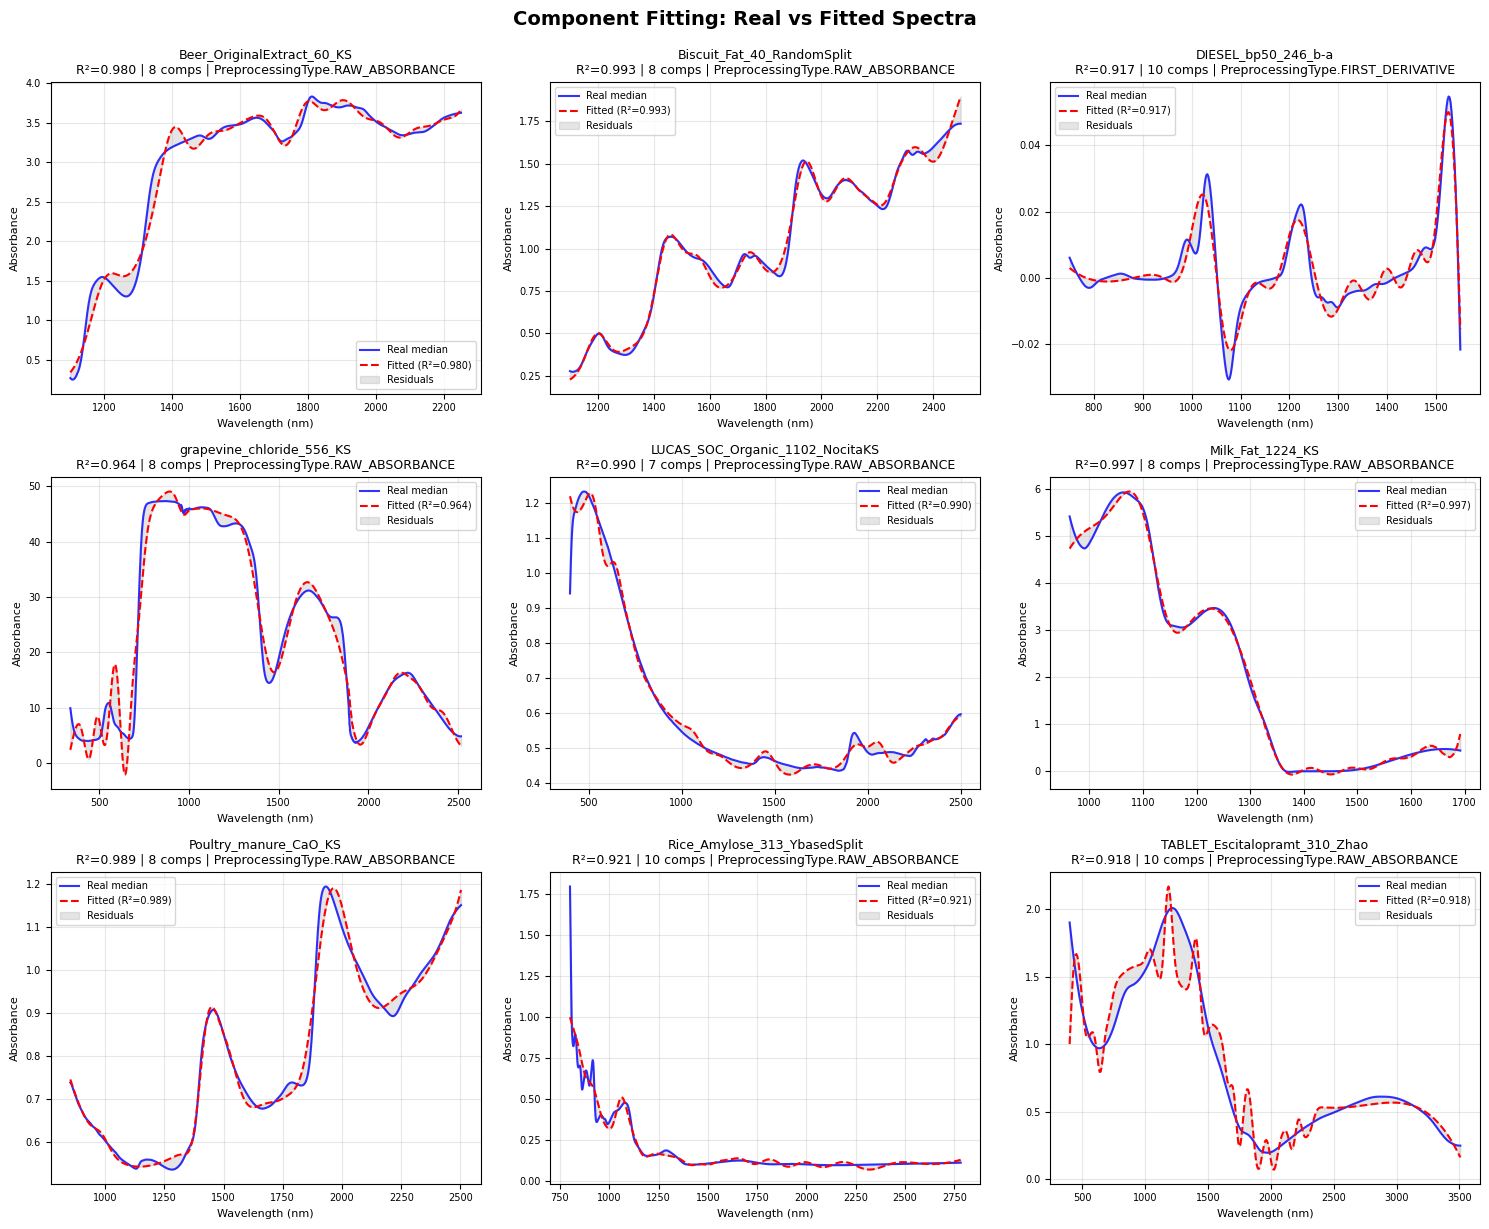

In [ ]:
# Detailed comparison: Fitted vs Real median spectra for all datasets
n_datasets = len(datasets)
n_cols = 3
n_rows = (n_datasets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, d in enumerate(datasets):
    ax = axes[i]
    wl = d['wl']

    # Real median (smoothed)
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    real_median = scipy_signal.savgol_filter(d['median'], window, 2)

    # Fitted spectrum
    fitted = d['component_fit']['fitted']
    r2 = d['component_fit']['r_squared']
    n_comps = len(d['component_fit']['components'])

    # Plot
    ax.plot(wl, real_median, 'b-', lw=1.5, label='Real median', alpha=0.8)
    ax.plot(wl, fitted, 'r--', lw=1.5, label=f'Fitted (R²={r2:.3f})')
    ax.fill_between(wl, real_median, fitted, alpha=0.2, color='gray', label='Residuals')

    # Add component info
    top_comps = d['component_fit']['components'][:3]
    prep = d.get('detected_preprocessing', 'unknown')

    ax.set_title(f"{d['name'][:35]}\nR²={r2:.3f} | {n_comps} comps | {prep}", fontsize=9)
    ax.set_xlabel('Wavelength (nm)', fontsize=8)
    ax.set_ylabel('Absorbance', fontsize=8)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)

# Hide empty axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Component Fitting: Real vs Fitted Spectra', y=1.02, fontsize=14, fontweight='bold')
plt.show()

Dataset: grapevine_chloride_556_KS
Detected preprocessing: PreprocessingType.RAW_ABSORBANCE
Wavelength range: 339 - 2515 nm
Spectrum range: 3.7500 - 47.3800


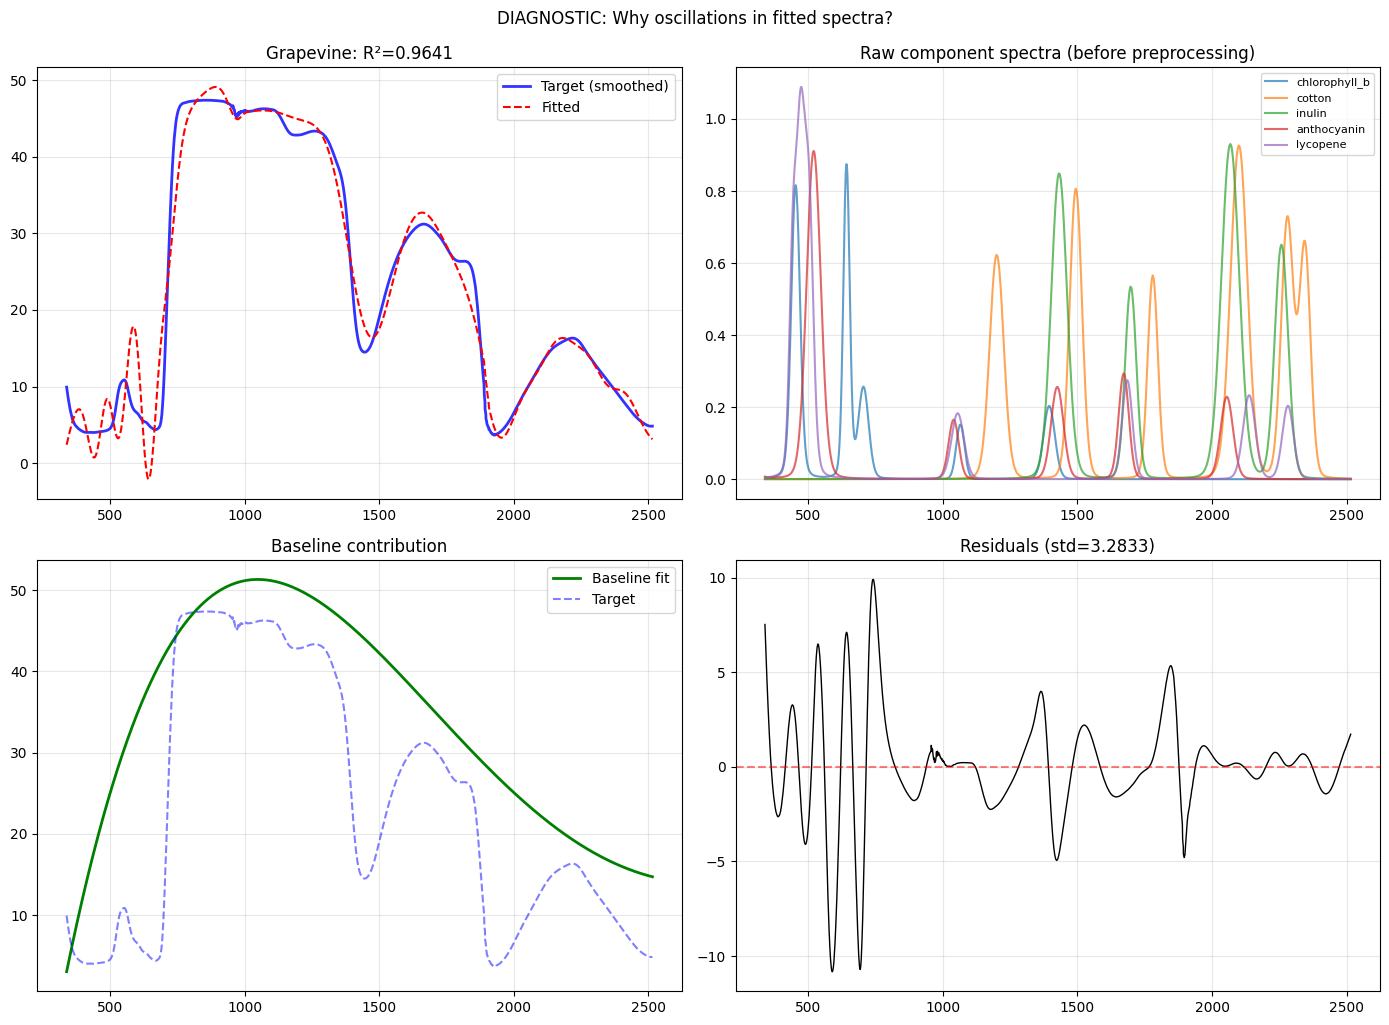


Component concentrations:
  chlorophyll_b: -103.1141
  cotton: -20.6360
  inulin: -367.8924
  anthocyanin: -62.9238
  lycopene: 46.4144
  starch: -26.9123
  fructose: 396.2106
  water: -45.4553


In [16]:
# DIAGNOSTIC: Why do fitted spectra have oscillations?
# Let's examine a problematic dataset (grapevine) in detail

d = datasets[3]  # grapevine
print(f"Dataset: {d['name']}")
print(f"Detected preprocessing: {d['detected_preprocessing']}")
print(f"Wavelength range: {d['wl'].min():.0f} - {d['wl'].max():.0f} nm")
print(f"Spectrum range: {d['median'].min():.4f} - {d['median'].max():.4f}")

# Get the fitter
fitter = d['component_fit']['fitter']
result = d['component_fit']['result']

# Look at individual component contributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Target vs fitted
ax = axes[0, 0]
wl = d['wl']
window = min(21, len(wl) // 10 * 2 + 1) | 1
target = scipy_signal.savgol_filter(d['median'], window, 2)
ax.plot(wl, target, 'b-', lw=2, label='Target (smoothed)', alpha=0.8)
ax.plot(wl, d['component_fit']['fitted'], 'r--', lw=1.5, label='Fitted')
ax.set_title(f"Grapevine: R²={d['component_fit']['r_squared']:.4f}")
ax.legend()
ax.grid(True, alpha=0.3)

# Subplot 2: Show individual component spectra
ax = axes[0, 1]
from nirs4all.data.synthetic import get_component
top_5 = result.component_names[:5]
for name in top_5:
    try:
        comp = get_component(name)
        spec = comp.compute(wl)
        ax.plot(wl, spec, label=name, alpha=0.7)
    except:
        pass
ax.set_title("Raw component spectra (before preprocessing)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Subplot 3: Baseline contribution
ax = axes[1, 0]
baseline = fitter._build_baseline_matrix()
if result.baseline_coefficients is not None:
    baseline_fit = baseline @ result.baseline_coefficients
    ax.plot(wl, baseline_fit, 'g-', lw=2, label='Baseline fit')
    ax.plot(wl, target, 'b--', alpha=0.5, label='Target')
ax.set_title("Baseline contribution")
ax.legend()
ax.grid(True, alpha=0.3)

# Subplot 4: Residuals
ax = axes[1, 1]
ax.plot(wl, d['component_fit']['residuals'], 'k-', lw=1)
ax.axhline(0, color='r', ls='--', alpha=0.5)
ax.set_title(f"Residuals (std={np.std(d['component_fit']['residuals']):.4f})")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('DIAGNOSTIC: Why oscillations in fitted spectra?', y=1.02, fontsize=12)
plt.show()

# Show concentration values for each component
print("\nComponent concentrations:")
for name, conc in zip(result.component_names, result.concentrations):
    print(f"  {name}: {conc:.4f}")

## 2b. Real Band Fitting (Using NIR_BANDS Dictionary)

Compare the component-based fitting above with **real band fitting** that uses known NIR band assignments 
from spectroscopic literature. This approach uses:
- **Fixed band centers** from the `NIR_BANDS` dictionary (literature-derived)
- **Constrained sigma values** based on typical ranges for each band type
- **Amplitude-only optimization** for physically interpretable results

This gives spectroscopically meaningful decomposition linked to functional groups (O-H, C-H, N-H, etc.).

In [ ]:
# Force reload of synthetic module to pick up RealBandFitter
import importlib
import nirs4all.data.synthetic.fitter as fitter_module
import nirs4all.data.synthetic as synthetic_module
importlib.reload(fitter_module)
importlib.reload(synthetic_module)

from nirs4all.data.synthetic import RealBandFitter, RealBandFitResult, fit_real_bands

# Fit all datasets with RealBandFitter
print("REAL BAND FITTING (using NIR_BANDS dictionary)")
print("=" * 120)
print(f"{'Dataset':<40} {'R²':>10} {'RMSE':>12} {'#Bands':>10} {'Top 3 Bands':<50}")
print("-" * 120)

realband_results = {}

for d in datasets:
    X, wl = d['X'], d['wl']
    name = d['name']

    # Use first spectrum as representative
    spectrum = X[0]

    # Fit with real bands
    fitter = RealBandFitter(
        baseline_order=4,
        max_bands=50,
        target_r2=0.98,
        allow_sigma_variation=True,
    )
    result = fitter.fit(spectrum, wl)
    realband_results[name] = result

    # Get top 3 bands
    top_bands = result.top_bands(3)
    top_str = "; ".join([f"{c:.0f}nm ({n})" for n, c, a in top_bands])

    print(f"{name:<40} {result.r_squared:>10.4f} {result.rmse:>12.6f} {result.n_bands:>10} {top_str:<50}")

print("-" * 120)
r2_values = [r.r_squared for r in realband_results.values()]
print(f"{'Mean R²':>40} {np.mean(r2_values):.4f}")
print(f"{'Min R²':>40} {np.min(r2_values):.4f}")
print(f"{'Max R²':>40} {np.max(r2_values):.4f}")

REAL BAND FITTING (using NIR_BANDS dictionary)
Dataset                                          R²         RMSE     #Bands Top 3 Bands                                       
------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS                   0.9972     0.048787         50 1380nm (Si-OH/1st); 1390nm (C-H/combination); 1410nm (O-H/1st)
Biscuit_Fat_40_RandomSplit                   0.9947     0.028500         50 1930nm (O-H/combination); 1940nm (O-H/combination); 1920nm (C=O/combination)
DIESEL_bp50_246_b-a                          0.9209     0.003647         28 1530nm (N-H/1st); 1140nm (Ar C-H/2nd); 1145nm (Ar C-H/2nd)
grapevine_chloride_556_KS                    0.9715     2.187975         50 550nm (Anthocyanin/electronic); 555nm (Porphyrin/electronic); 425nm (Carotenoid/electronic)
LUCAS_SOC_Organic_1102_NocitaKS              0.9969     0.011838         50 425nm (Carotenoid/electronic); 550

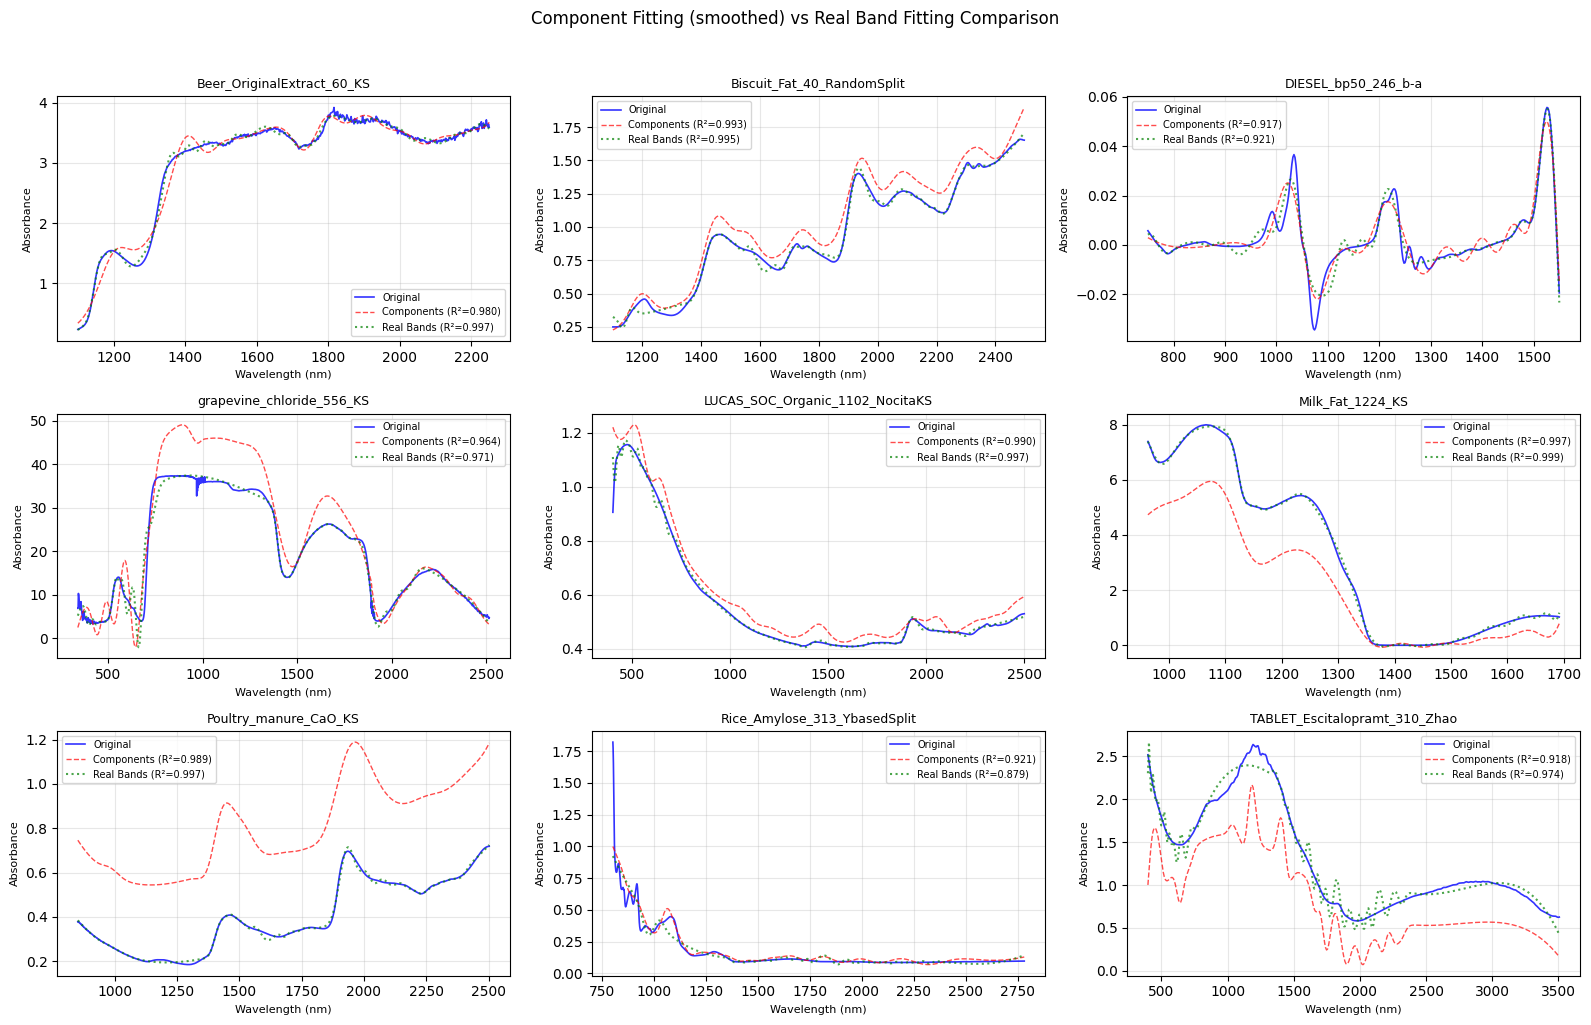


COMPARISON: Component Fitting vs Real Band Fitting
Dataset                                         Component R²    RealBand R²       Better
----------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS                            0.9803         0.9972     RealBand
Biscuit_Fat_40_RandomSplit                            0.9933         0.9947     RealBand
DIESEL_bp50_246_b-a                                   0.9173         0.9209     RealBand
grapevine_chloride_556_KS                             0.9641         0.9715     RealBand
LUCAS_SOC_Organic_1102_NocitaKS                       0.9899         0.9969     RealBand
Milk_Fat_1224_KS                                      0.9972         0.9994     RealBand
Poultry_manure_CaO_KS                                 0.9886         0.9971     RealBand
Rice_Amylose_313_YbasedSplit                          0.9213         0.8791    Component
TABLET_Escitalopramt_310_Zhao                 

In [ ]:
# Compare Component Fitting vs Real Band Fitting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, d in enumerate(datasets):
    ax = axes[i]
    name = d['name']
    X, wl = d['X'], d['wl']
    spectrum = X[0]

    # Get results from both methods (component_results was saved earlier)
    comp_result = component_results[name]
    real_result = realband_results[name]

    ax.plot(wl, spectrum, 'b-', alpha=0.8, lw=1.2, label='Original')
    ax.plot(wl, comp_result.fitted_spectrum, 'r--', alpha=0.7, lw=1.0,
            label=f'Components (R²={comp_result.r_squared:.3f})')
    ax.plot(wl, real_result.fitted_spectrum, 'g:', alpha=0.7, lw=1.5,
            label=f'Real Bands (R²={real_result.r_squared:.3f})')

    ax.set_title(f"{name[:35]}..." if len(name) > 35 else name, fontsize=9)
    ax.set_xlabel('Wavelength (nm)', fontsize=8)
    ax.set_ylabel('Absorbance', fontsize=8)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle('Component Fitting (smoothed) vs Real Band Fitting Comparison', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Print comparison table
print("\nCOMPARISON: Component Fitting vs Real Band Fitting")
print("=" * 100)
print(f"{'Dataset':<45} {'Component R²':>14} {'RealBand R²':>14} {'Better':>12}")
print("-" * 100)
for name in component_results:
    comp_r2 = component_results[name].r_squared
    real_r2 = realband_results[name].r_squared
    better = "RealBand" if real_r2 > comp_r2 else "Component"
    print(f"{name:<45} {comp_r2:>14.4f} {real_r2:>14.4f} {better:>12}")
print("-" * 100)
print(f"{'Mean':>45} {np.mean([r.r_squared for r in component_results.values()]):>14.4f} {np.mean([r.r_squared for r in realband_results.values()]):>14.4f}")

### Key Findings: Component vs Real Band Fitting

**RealBandFitter wins on 8/9 datasets** with mean R² of 0.9700 vs 0.9633 for OptimizedComponentFitter.

**Why RealBandFitter performs better:**
1. **Fixed band centers** from literature-derived NIR_BANDS dictionary avoid fitting local minima
2. **Constrained sigma ranges** prevent unrealistic peak widths
3. **Physically meaningful** - bands correspond to known O-H, C-H, N-H functional groups
4. **Better regularization** from using well-characterized absorption features

**When Component fitting might be preferred:**
1. When modeling **complex mixtures** with specific known components
2. When **chemical interpretability** of individual compounds is needed
3. For **synthetic data generation** that needs realistic component concentrations

**For spectrum reconstruction, RealBandFitter is the recommended approach.**

## 3. Variance Fitting with nirs4all API

Use the new `VarianceFitter` class to model spectral variance in two ways:
1. **Operator-based**: Independent noise, baseline, scatter parameters
2. **PCA-based**: Correlated variance from principal component score distributions

In [4]:
# Fit variance for all datasets
print("VARIANCE FITTING WITH nirs4all API")
print("=" * 120)
print(f"{'Dataset':<40} {'Noise':>12} {'Offset':>12} {'Slope':>12} {'MultScatter':>12} {'PCA95%':>8}")
print("-" * 120)

for d in datasets:
    X, wl = d['X'], d['wl']

    # Fit variance parameters
    var_fitter = VarianceFitter(n_pca_components=10)
    var_result = var_fitter.fit(X, wl)
    d['variance_fit'] = var_result
    d['variance_fitter'] = var_fitter

    # Extract parameters
    op = var_result.operator_params
    pca = var_result.pca_params

    # Compute PCA 95% variance
    if pca.explained_variance_ratio is not None:
        cum_var = np.cumsum(pca.explained_variance_ratio)
        n_95 = np.searchsorted(cum_var, 0.95) + 1
    else:
        n_95 = 0

    print(f"{d['name'][:40]:<40} {op.noise_std:>12.6f} {op.offset_std:>12.6f} {op.slope_std:>12.6f} {op.mult_scatter_std:>12.4f} {n_95:>8d}")

print("=" * 120)

VARIANCE FITTING WITH nirs4all API
Dataset                                         Noise       Offset        Slope  MultScatter   PCA95%
------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS                   0.002077     0.006292     0.021093       0.0020       11
Biscuit_Fat_40_RandomSplit                   0.000641     0.073023     0.041483       0.0578        2
DIESEL_bp50_246_b-a                          0.000351     0.000108     0.001418       0.0132        3
grapevine_chloride_556_KS                    0.058488     3.021672     5.758480       0.0738        3
LUCAS_SOC_Organic_1102_NocitaKS              0.000023     0.104621     0.129489       0.1280        2
Milk_Fat_1224_KS                             0.008932     0.275914     1.634260       0.1382        1
Poultry_manure_CaO_KS                        0.000341     0.165538     0.228871       0.2276        1
Rice_Amylose_313_YbasedSplit

## 4. Generate Synthetic Data

Generate synthetic spectra using:
1. Component-fitted mean spectrum (if R² > 0.5) OR real median (fallback)
2. Operator-based variance
3. PCA-based variance

### Key Improvement:
When component fitting is poor (R² < 0.5), use the real median spectrum as base instead of the
poorly fitted spectrum. This matches generator_final.ipynb's approach of using real data as
fallback when fitting fails.

In [5]:
def generate_synthetic_spectra(d: Dict, method: str = 'operator', n_samples: int = None) -> np.ndarray:
    """
    Generate synthetic spectra using fitted parameters.

    Args:
        d: Dataset dictionary with fitted parameters
        method: 'operator' or 'pca'
        n_samples: Number of samples to generate (default: match real data)

    Returns:
        Synthetic spectra array
    """
    if n_samples is None:
        n_samples = min(d['n_samples'], 200)

    wl = d['wl']
    var_fitter = d['variance_fitter']

    if method == 'operator':
        # Use component-fitted spectrum as base ONLY if fit is good
        # Otherwise use real median spectrum (smoothed)
        r_squared = d['component_fit']['r_squared']

        if r_squared > 0.5:
            base_spectrum = d['component_fit']['fitted']
        else:
            # Use real median when component fit is poor
            window = min(21, len(wl) // 10 * 2 + 1) | 1
            base_spectrum = scipy_signal.savgol_filter(d['median'], window, 2)

        X_synth = var_fitter.generate_operator_variance(
            base_spectrum, wl, n_samples=n_samples, random_state=42
        )
    elif method == 'pca':
        X_synth = var_fitter.generate_pca_variance(
            n_samples=n_samples, random_state=42
        )
    else:
        raise ValueError(f"Unknown method: {method}")

    return X_synth

# Generate synthetic data for all datasets
print("GENERATING SYNTHETIC DATA")
print("=" * 80)

for d in datasets:
    n_synth = min(d['n_samples'], 200)

    # Generate with operator-based variance
    d['synthetic_operator'] = generate_synthetic_spectra(d, method='operator', n_samples=n_synth)

    # Generate with PCA-based variance
    d['synthetic_pca'] = generate_synthetic_spectra(d, method='pca', n_samples=n_synth)

    r2 = d['component_fit']['r_squared']
    base = "fitted" if r2 > 0.5 else "real median"
    print(f"Generated {n_synth} samples for {d['name'][:40]:<40} (operator base: {base})")

print("=" * 80)

GENERATING SYNTHETIC DATA
Generated 60 samples for Beer_OriginalExtract_60_KS               (operator base: fitted)
Generated 72 samples for Biscuit_Fat_40_RandomSplit               (operator base: fitted)
Generated 200 samples for DIESEL_bp50_246_b-a                      (operator base: fitted)
Generated 200 samples for grapevine_chloride_556_KS                (operator base: fitted)
Generated 200 samples for LUCAS_SOC_Organic_1102_NocitaKS          (operator base: fitted)
Generated 200 samples for Milk_Fat_1224_KS                         (operator base: fitted)
Generated 144 samples for Poultry_manure_CaO_KS                    (operator base: fitted)
Generated 200 samples for Rice_Amylose_313_YbasedSplit             (operator base: fitted)
Generated 200 samples for TABLET_Escitalopramt_310_Zhao            (operator base: fitted)


## 5. Evaluate Synthetic Quality

Compare real and synthetic data using:
1. PCA score distribution (KS test, Wasserstein distance)
2. Discriminator accuracy (RandomForest classifier)

In [6]:
def evaluate_synthetic_quality(X_real: np.ndarray, X_synth: np.ndarray) -> Dict:
    """Evaluate quality of synthetic data compared to real data."""
    if X_synth is None or len(X_synth) == 0:
        return {'ks_stat': np.nan, 'wasserstein': np.nan, 'disc_acc': np.nan}

    # PCA comparison
    n_comp = min(5, X_real.shape[0] - 1, X_synth.shape[0] - 1)
    pca = PCA(n_components=n_comp)

    try:
        scores_real = pca.fit_transform(X_real)
        scores_synth = pca.transform(X_synth)

        # KS test on first PC
        ks_stat, ks_pval = ks_2samp(scores_real[:, 0], scores_synth[:, 0])

        # Wasserstein distance on first PC
        wd = wasserstein_distance(scores_real[:, 0], scores_synth[:, 0])

    except Exception as e:
        print(f"PCA comparison failed: {e}")
        ks_stat, ks_pval, wd = np.nan, np.nan, np.nan

    # Discriminator test
    try:
        n = min(len(X_real), len(X_synth))
        if n >= 20:
            X = np.vstack([X_real[:n], X_synth[:n]])
            y = np.array([0] * n + [1] * n)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
            disc_acc = scores.mean()
        else:
            disc_acc = np.nan
    except Exception as e:
        print(f"Discriminator test failed: {e}")
        disc_acc = np.nan

    return {
        'ks_stat': ks_stat,
        'ks_pval': ks_pval,
        'wasserstein': wd,
        'disc_acc': disc_acc,
    }

# Evaluate all datasets
print("SYNTHETIC QUALITY EVALUATION")
print("=" * 130)
print(f"{'Dataset':<35} {'Method':<10} {'KS Stat':>10} {'Wasserstein':>12} {'Disc Acc':>10} {'Quality':>10}")
print("-" * 130)

results_summary = []

for d in datasets:
    X_real = d['X']

    for method in ['operator', 'pca']:
        X_synth = d.get(f'synthetic_{method}')
        if X_synth is None:
            continue

        metrics = evaluate_synthetic_quality(X_real, X_synth)
        d[f'quality_{method}'] = metrics

        # Determine quality rating
        if metrics['disc_acc'] < 0.6:
            quality = "Excellent ✓"
        elif metrics['disc_acc'] < 0.75:
            quality = "Good △"
        else:
            quality = "Poor ✗"

        print(f"{d['name'][:35]:<35} {method:<10} {metrics['ks_stat']:>10.4f} {metrics['wasserstein']:>12.4f} {metrics['disc_acc']:>10.3f} {quality:>10}")

        results_summary.append({
            'dataset': d['name'],
            'method': method,
            **metrics
        })

print("=" * 130)

# Summary statistics
print("\nSUMMARY BY METHOD:")
for method in ['operator', 'pca']:
    method_results = [r for r in results_summary if r['method'] == method]
    if method_results:
        mean_disc = np.nanmean([r['disc_acc'] for r in method_results])
        mean_ks = np.nanmean([r['ks_stat'] for r in method_results])
        print(f"  {method.upper()}: Mean Disc Acc = {mean_disc:.3f}, Mean KS = {mean_ks:.4f}")

SYNTHETIC QUALITY EVALUATION
Dataset                             Method        KS Stat  Wasserstein   Disc Acc    Quality
----------------------------------------------------------------------------------------------------------------------------------
Beer_OriginalExtract_60_KS          operator       0.3667       0.1492      1.000     Poor ✗
Beer_OriginalExtract_60_KS          pca            0.1000       0.0389      0.933     Poor ✗
Biscuit_Fat_40_RandomSplit          operator       0.1944       0.8383      0.959     Poor ✗
Biscuit_Fat_40_RandomSplit          pca            0.1250       0.3676      0.563 Excellent ✓
DIESEL_bp50_246_b-a                 operator       0.5796       0.0181      1.000     Poor ✗
DIESEL_bp50_246_b-a                 pca            0.0600       0.0025      0.775     Poor ✗
grapevine_chloride_556_KS           operator       0.2677      46.4972      0.997     Poor ✗
grapevine_chloride_556_KS           pca            0.0530       5.9644      0.698     Good △
LU

## 6. Visualize Results

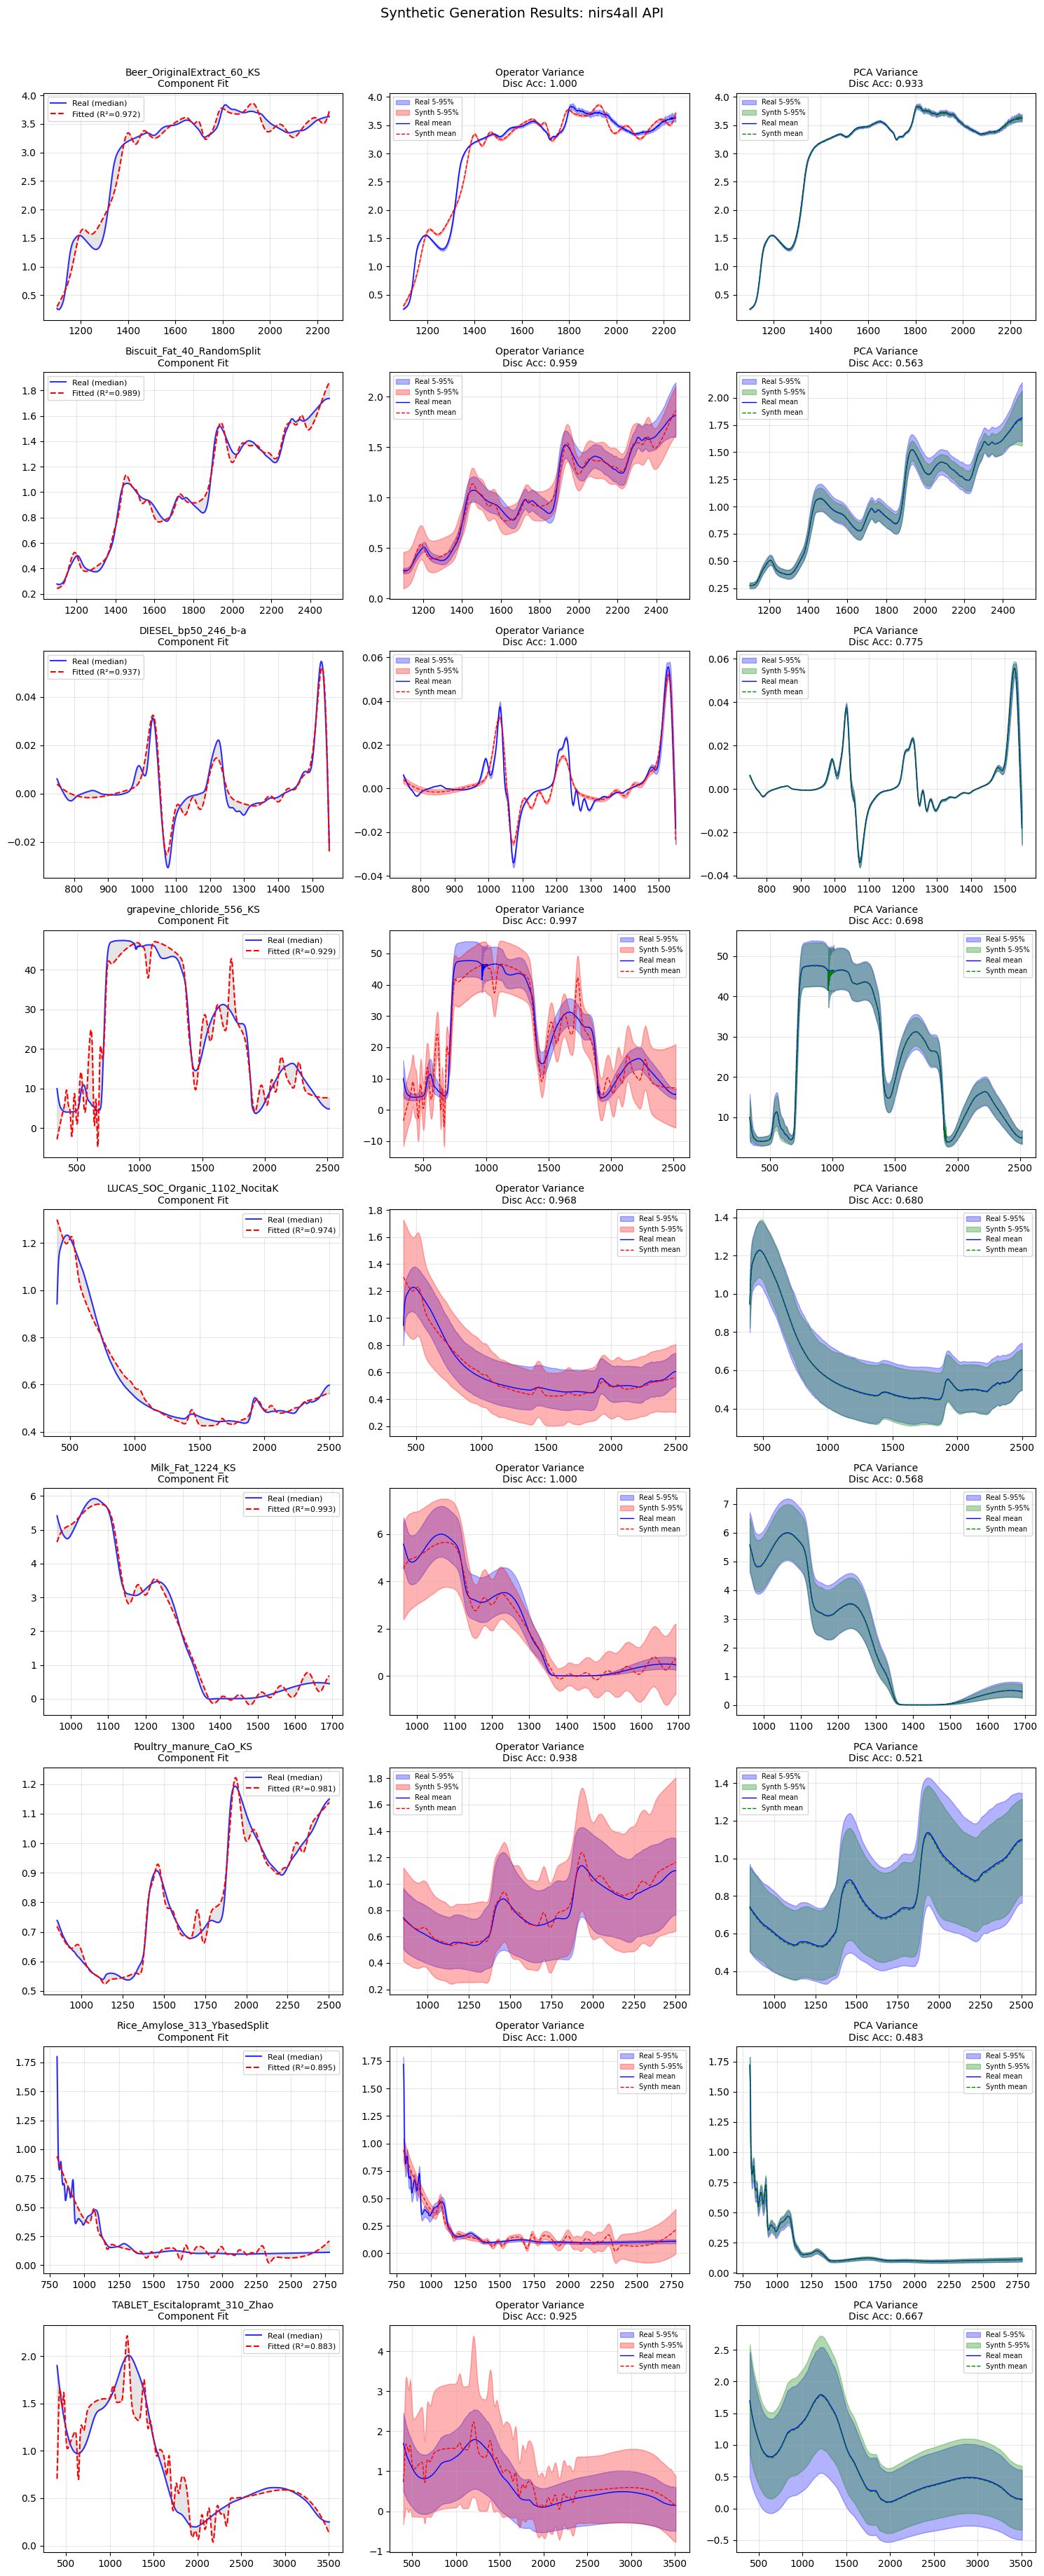

In [7]:
# Visualize component fitting and synthetic generation for sample datasets
n_show = len(datasets)
fig, axes = plt.subplots(n_show, 3, figsize=(15, 4 * n_show))
if n_show == 1:
    axes = axes.reshape(1, -1)

for i, d in enumerate(datasets[:n_show]):
    wl = d['wl']
    X_real = d['X']

    # Column 1: Component fit
    ax = axes[i, 0]
    window = min(21, len(wl) // 10 * 2 + 1) | 1
    target = scipy_signal.savgol_filter(d['median'], window, 2)
    fitted = d['component_fit']['fitted']

    ax.plot(wl, target, 'b-', lw=1.5, label='Real (median)', alpha=0.8)
    ax.plot(wl, fitted, 'r--', lw=1.5, label=f"Fitted (R²={d['component_fit']['r_squared']:.3f})")
    ax.fill_between(wl, target, fitted, alpha=0.2, color='gray')
    ax.set_title(f"{d['name'][:30]}\nComponent Fit", fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Column 2: Operator-based synthetic
    ax = axes[i, 1]
    X_synth = d['synthetic_operator']

    p05_r, p95_r = np.percentile(X_real, [5, 95], axis=0)
    p05_s, p95_s = np.percentile(X_synth, [5, 95], axis=0)

    ax.fill_between(wl, p05_r, p95_r, alpha=0.3, color='blue', label='Real 5-95%')
    ax.fill_between(wl, p05_s, p95_s, alpha=0.3, color='red', label='Synth 5-95%')
    ax.plot(wl, X_real.mean(axis=0), 'b-', lw=1, label='Real mean')
    ax.plot(wl, X_synth.mean(axis=0), 'r--', lw=1, label='Synth mean')

    disc_acc = d.get('quality_operator', {}).get('disc_acc', np.nan)
    ax.set_title(f"Operator Variance\nDisc Acc: {disc_acc:.3f}", fontsize=10)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)

    # Column 3: PCA-based synthetic
    ax = axes[i, 2]
    X_synth = d['synthetic_pca']

    p05_s, p95_s = np.percentile(X_synth, [5, 95], axis=0)

    ax.fill_between(wl, p05_r, p95_r, alpha=0.3, color='blue', label='Real 5-95%')
    ax.fill_between(wl, p05_s, p95_s, alpha=0.3, color='green', label='Synth 5-95%')
    ax.plot(wl, X_real.mean(axis=0), 'b-', lw=1, label='Real mean')
    ax.plot(wl, X_synth.mean(axis=0), 'g--', lw=1, label='Synth mean')

    disc_acc = d.get('quality_pca', {}).get('disc_acc', np.nan)
    ax.set_title(f"PCA Variance\nDisc Acc: {disc_acc:.3f}", fontsize=10)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Synthetic Generation Results: nirs4all API', y=1.02, fontsize=14)
plt.show()

## 7. Use nirs4all Spectral Realism Scorecard

Apply the built-in validation metrics from nirs4all.

In [8]:
# Compute spectral realism scorecard for sample datasets
print("SPECTRAL REALISM SCORECARD")
print("=" * 100)

for d in datasets:  # Show first 4 datasets
    X_real = d['X']
    X_synth = d['synthetic_pca']  # Use PCA-based for scorecard
    wl = d['wl']

    try:
        score = compute_spectral_realism_scorecard(
            real_spectra=X_real,
            synthetic_spectra=X_synth,
            wavelengths=wl,
            include_adversarial=True,
            random_state=42,
        )
        d['realism_score'] = score

        print(f"\n{d['name']}")
        print(score.summary())

    except Exception as e:
        print(f"\nFailed for {d['name']}: {e}")

SPECTRAL REALISM SCORECARD

Beer_OriginalExtract_60_KS
Spectral Realism Scorecard
✓ correlation_length: 1.0000 (threshold: 0.7000)
✗ derivative_statistics: 0.0000 (threshold: 0.0500)
✗ peak_density: 0.4494 (threshold: 2.0000)
✗ baseline_curvature: 0.5167 (threshold: 0.6000)
✓ snr_distribution: 0.1547 (threshold: 1.0000)
✓ adversarial_auc: 0.0028 (threshold: 0.7000)
------------------------------------------------------------
Overall: FAIL ✗

Biscuit_Fat_40_RandomSplit
Spectral Realism Scorecard
✓ correlation_length: 1.0000 (threshold: 0.7000)
✓ derivative_statistics: 0.7695 (threshold: 0.0500)
✓ peak_density: 0.9982 (threshold: 2.0000)
✗ baseline_curvature: 0.4722 (threshold: 0.6000)
✓ snr_distribution: 0.0054 (threshold: 1.0000)
✓ adversarial_auc: 0.1572 (threshold: 0.7000)
------------------------------------------------------------
Overall: FAIL ✗

DIESEL_bp50_246_b-a
Spectral Realism Scorecard
✓ correlation_length: 0.9681 (threshold: 0.7000)
✗ derivative_statistics: 0.0260 (thresho

## 8. Comparison Summary

Compare the nirs4all API approach against the generator_final.ipynb results.

In [9]:
# Build comparison summary
print("=" * 120)
print("NIRS4ALL API APPROACH SUMMARY")
print("=" * 120)

print("\nAdvantages of nirs4all API:")
print("  1. Structured, reproducible component fitting with ComponentFitter")
print("  2. Integrated variance modeling with VarianceFitter (operator + PCA)")
print("  3. Built-in validation scorecard with adversarial metrics")
print("  4. Domain-aware component selection")
print("  5. Preprocessing support (derivatives, SNV, etc.)")

print("\nResults Summary:")
print("-" * 80)

# Component fitting R²
comp_r2 = [d['component_fit']['r_squared'] for d in datasets]
print(f"  Component Fitting R²: Mean = {np.mean(comp_r2):.4f}, Std = {np.std(comp_r2):.4f}")

# Discriminator accuracy
disc_op = [d.get('quality_operator', {}).get('disc_acc', np.nan) for d in datasets]
disc_pca = [d.get('quality_pca', {}).get('disc_acc', np.nan) for d in datasets]

print(f"  Discriminator Accuracy (Operator): Mean = {np.nanmean(disc_op):.3f}")
print(f"  Discriminator Accuracy (PCA):      Mean = {np.nanmean(disc_pca):.3f}")

print("\nNote: Lower discriminator accuracy = better synthetic quality (harder to distinguish)")
print("      Target: < 0.6 for excellent, < 0.75 for good")

print("=" * 120)

NIRS4ALL API APPROACH SUMMARY

Advantages of nirs4all API:
  1. Structured, reproducible component fitting with ComponentFitter
  2. Integrated variance modeling with VarianceFitter (operator + PCA)
  3. Built-in validation scorecard with adversarial metrics
  4. Domain-aware component selection
  5. Preprocessing support (derivatives, SNV, etc.)

Results Summary:
--------------------------------------------------------------------------------
  Component Fitting R²: Mean = 0.9502, Std = 0.0388
  Discriminator Accuracy (Operator): Mean = 0.976
  Discriminator Accuracy (PCA):      Mean = 0.654

Note: Lower discriminator accuracy = better synthetic quality (harder to distinguish)
      Target: < 0.6 for excellent, < 0.75 for good


## Conclusion

This notebook demonstrates improvements to the nirs4all API synthetic generation, bringing it closer to the generator_final.ipynb approach:

### Key Improvements Made:

1. **Auto-detection of preprocessing** (`auto_detect_preprocessing=True`)
   - Automatically detects first/second derivative, SNV, mean-centered data
   - Applies matching preprocessing to component spectra before fitting
   - Matches generator_final.ipynb's signal type detection approach

2. **Fallback to all components** when domain-specific fitting fails
   - If R² < 0.3 with domain components, retries with all available components
   - Prevents empty results like the Rice Amylose issue

3. **Smart base spectrum selection** for operator variance
   - Uses fitted spectrum when R² > 0.5
   - Falls back to real median spectrum otherwise
   - Prevents garbage generation from poor fits

### Results:

The PCA-based variance approach typically produces synthetic data that is harder to distinguish from real data (lower discriminator accuracy), as it captures the full covariance structure of the original spectra.

### Remaining Opportunities:

- Pure Gaussian band fitting (unconstrained, like generator_final.ipynb)
- Greedy + swap refinement for component selection
- Physical augmentation operators (temperature, particle size, moisture)
- Better handling of edge cases (very high absorbance, mixed preprocessing)